In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import shapely.geometry

from utils import get_data, tech_map
from utils import tech_order, tech_colors
from utils import get_data_sftp

from datetime import datetime
from pytz import timezone
import os

plt.style.use(['science','ieee'])
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Load the shape file
wecc_load_areas = gpd.read_file('load_zones/wecc_load_areas.shp')
wecc_load_areas.rename(columns={'LOAD_AREA':'load_zone'}, inplace=True)
wecc_load_areas['centroid'] = wecc_load_areas['geometry'].apply(lambda x: x.centroid)
wecc_load_areas.set_index('load_zone', inplace=True)



In [4]:
def read_scenarios(file_name: str):
    input_scenarios=pd.read_csv(file_name, index_col=False)
    scenario = list(input_scenarios['scenario'])
    short_names = dict(input_scenarios[['scenario', 'short_name']].values)
    order= dict(input_scenarios[['short_name', 'order']].values)
    return scenario, short_names, order

In [5]:
def tech_generation(scenario, short_names, order, analysis_period, analysis_tech):
    dispatch_annual_summary = get_data(scenario, "dispatch_annual_summary.csv")
    dispatch_annual_summary.replace({"scenario": short_names}, inplace=True)
    
    if len(analysis_period)==0:
        analysis_period = dispatch_annual_summary.period.unique()
    if len(analysis_tech)==0:
        analysis_tech = dispatch_annual_summary.gen_energy_source.unique()

    dispatch_annual_summary = dispatch_annual_summary.loc[dispatch_annual_summary.gen_energy_source.isin(analysis_tech) &
                                                          dispatch_annual_summary.period.isin(analysis_period)]
    dispatch_annual_summary = dispatch_annual_summary[['tech_map','period', 'Energy_GWh_typical_yr','scenario']]
    dispatch_annual_summary = dispatch_annual_summary.pivot_table(index=['scenario','tech_map','period'], values=['Energy_GWh_typical_yr'], aggfunc=np.sum).reset_index(drop=False)
    total = dispatch_annual_summary.pivot_table(index='scenario', values='Energy_GWh_typical_yr', aggfunc=np.sum).reset_index(drop=False)
    total.rename(columns={'Energy_GWh_typical_yr' : 'Total_Energy_GWh_typical_yr'}, inplace=True)    
    dispatch_annual_summary = pd.merge(left = dispatch_annual_summary, right=total, on='scenario')
    
    dispatch_annual_summary['relative'] = dispatch_annual_summary['Energy_GWh_typical_yr']/dispatch_annual_summary['Total_Energy_GWh_typical_yr']*100

    return  dispatch_annual_summary, total

In [49]:
def tech_generation_by_zone(scenario, short_names, order, analysis_period, analysis_tech, analysis_zones):
    dispatch_annual_summary = get_data(scenario, "dispatch_zonal_annual_summary.csv")
    dispatch_annual_summary.replace({"scenario": short_names}, inplace=True)
    
    if len(analysis_period)==0:
        analysis_period = dispatch_annual_summary.period.unique()
    if len(analysis_tech)==0:
        analysis_tech = dispatch_annual_summary.gen_energy_source.unique()
    if len(analysis_zones)==0:
        analysis_zones = dispatch_annual_summary.gen_load_zone.unique()

    dispatch_annual_summary = dispatch_annual_summary.loc[dispatch_annual_summary.gen_energy_source.isin(analysis_tech) &
                                                          dispatch_annual_summary.period.isin(analysis_period)  &
                                                          dispatch_annual_summary.gen_load_zone.isin(analysis_zones)]
    dispatch_annual_summary = dispatch_annual_summary[['gen_load_zone','tech_map','period', 'Energy_GWh_typical_yr','scenario']]
    dispatch_annual_summary.rename(columns={'gen_load_zone' : 'load_zone'}, inplace=True)
    dispatch_annual_summary = dispatch_annual_summary.drop_duplicates().groupby(['load_zone', 'tech_map', 'period', 'scenario'], sort=False, as_index=False).sum()

    total_by_zone= dispatch_annual_summary.pivot_table(index = 'load_zone', values = 'Energy_GWh_typical_yr', aggfunc=np.sum)
    total_by_zone.rename(columns={'Energy_GWh_typical_yr' : 'Total_by_zone'}, inplace=True)
    total_by_zone.reset_index(inplace=True)

    dispatch_annual_summary = pd.merge(left=dispatch_annual_summary, right=total_by_zone, on='load_zone')
    dispatch_annual_summary ['Energy_relative'] = dispatch_annual_summary ['Energy_GWh_typical_yr']/dispatch_annual_summary ['Total_by_zone']
    dispatch_annual_summary = dispatch_annual_summary .fillna(0)
    dispatch_annual_summary = dispatch_annual_summary[dispatch_annual_summary.Total_by_zone != 0]

    return  dispatch_annual_summary

In [7]:
scenario, short_names, order = read_scenarios("input_scenarios_wecc.csv")

folder_to_save_results='paper/'

#Check if the directory exists. If not, then create the directory.
if not os.path.exists(folder_to_save_results):
    os.makedirs(folder_to_save_results)

In [50]:
analysis_zones=[] 
analysis_period=[]
analysis_tech=['Solar', 'Wind']

zone_annual_gen = tech_generation_by_zone('baseline_pverde_ldes_5', {'baseline_pverde_ldes_5': 5}, {5: 0},analysis_period, analysis_tech, analysis_zones)
zone_annual_gen

,load_zone,tech_map,period,scenario,Energy_GWh_typical_yr,Total_by_zone,Energy_relative
11,AZ_APS_N,Solar,2035,5,"1,213.60","1,213.60",1.00
12,AZ_APS_N,Wind,2035,5,0.00,"1,213.60",0.00
13,AZ_APS_N,Biomass,2035,5,0.00,"1,213.60",0.00
14,AZ_APS_N,Coal,2035,5,0.00,"1,213.60",0.00
15,AZ_APS_N,Gas,2035,5,0.00,"1,213.60",0.00
...,...,...,...,...,...,...,...
545,WY_SW,Hydro,2035,5,0.00,210.76,0.00
546,WY_SW,Nuclear,2035,5,0.00,210.76,0.00
547,WY_SW,Oil,2035,5,0.00,210.76,0.00
548,WY_SW,Storage,2035,5,0.00,210.76,0.00


In [51]:
zone_annual_gen_by_tech = zone_annual_gen.pivot_table(index='load_zone', columns='tech_map', values='Energy_relative')

zone_annual_gen_by_tech = pd.merge(left =zone_annual_gen_by_tech, right=zone_annual_gen[['load_zone', 'Total_by_zone']].drop_duplicates().set_index('load_zone'), left_index=True, right_index=True)
zone_annual_gen_by_tech = pd.merge(left= zone_annual_gen_by_tech, right=wecc_load_areas[['geometry', 'centroid']], left_index=True, right_index=True)
zone_annual_gen_by_tech.head()

,Solar,Wind,Biomass,Coal,Gas,Geothermal,Hydro,Nuclear,Oil,Storage,Waste,Total_by_zone,geometry,centroid
load_zone,,,,,,,,,,,,,,
AZ_APS_N,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"1,213.60","POLYGON ((-113.33350 34.53654, -113.33358 34.6...",POINT (-112.24571 35.67142)
AZ_APS_SW,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"37,937.00","POLYGON ((-112.60776 31.81579, -112.84735 31.8...",POINT (-113.40839 33.22903)
AZ_NM_N,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"5,291.40","POLYGON ((-109.04522 36.99908, -108.95440 36.9...",POINT (-109.23803 36.13718)
AZ_NW,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"7,607.90","POLYGON ((-114.13828 34.30323, -114.14093 34.3...",POINT (-113.97357 35.21137)
AZ_PHX,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"25,554.00","POLYGON ((-112.37619 33.67010, -112.31845 33.6...",POINT (-111.52754 33.54230)


(28.922504, 61.015181)

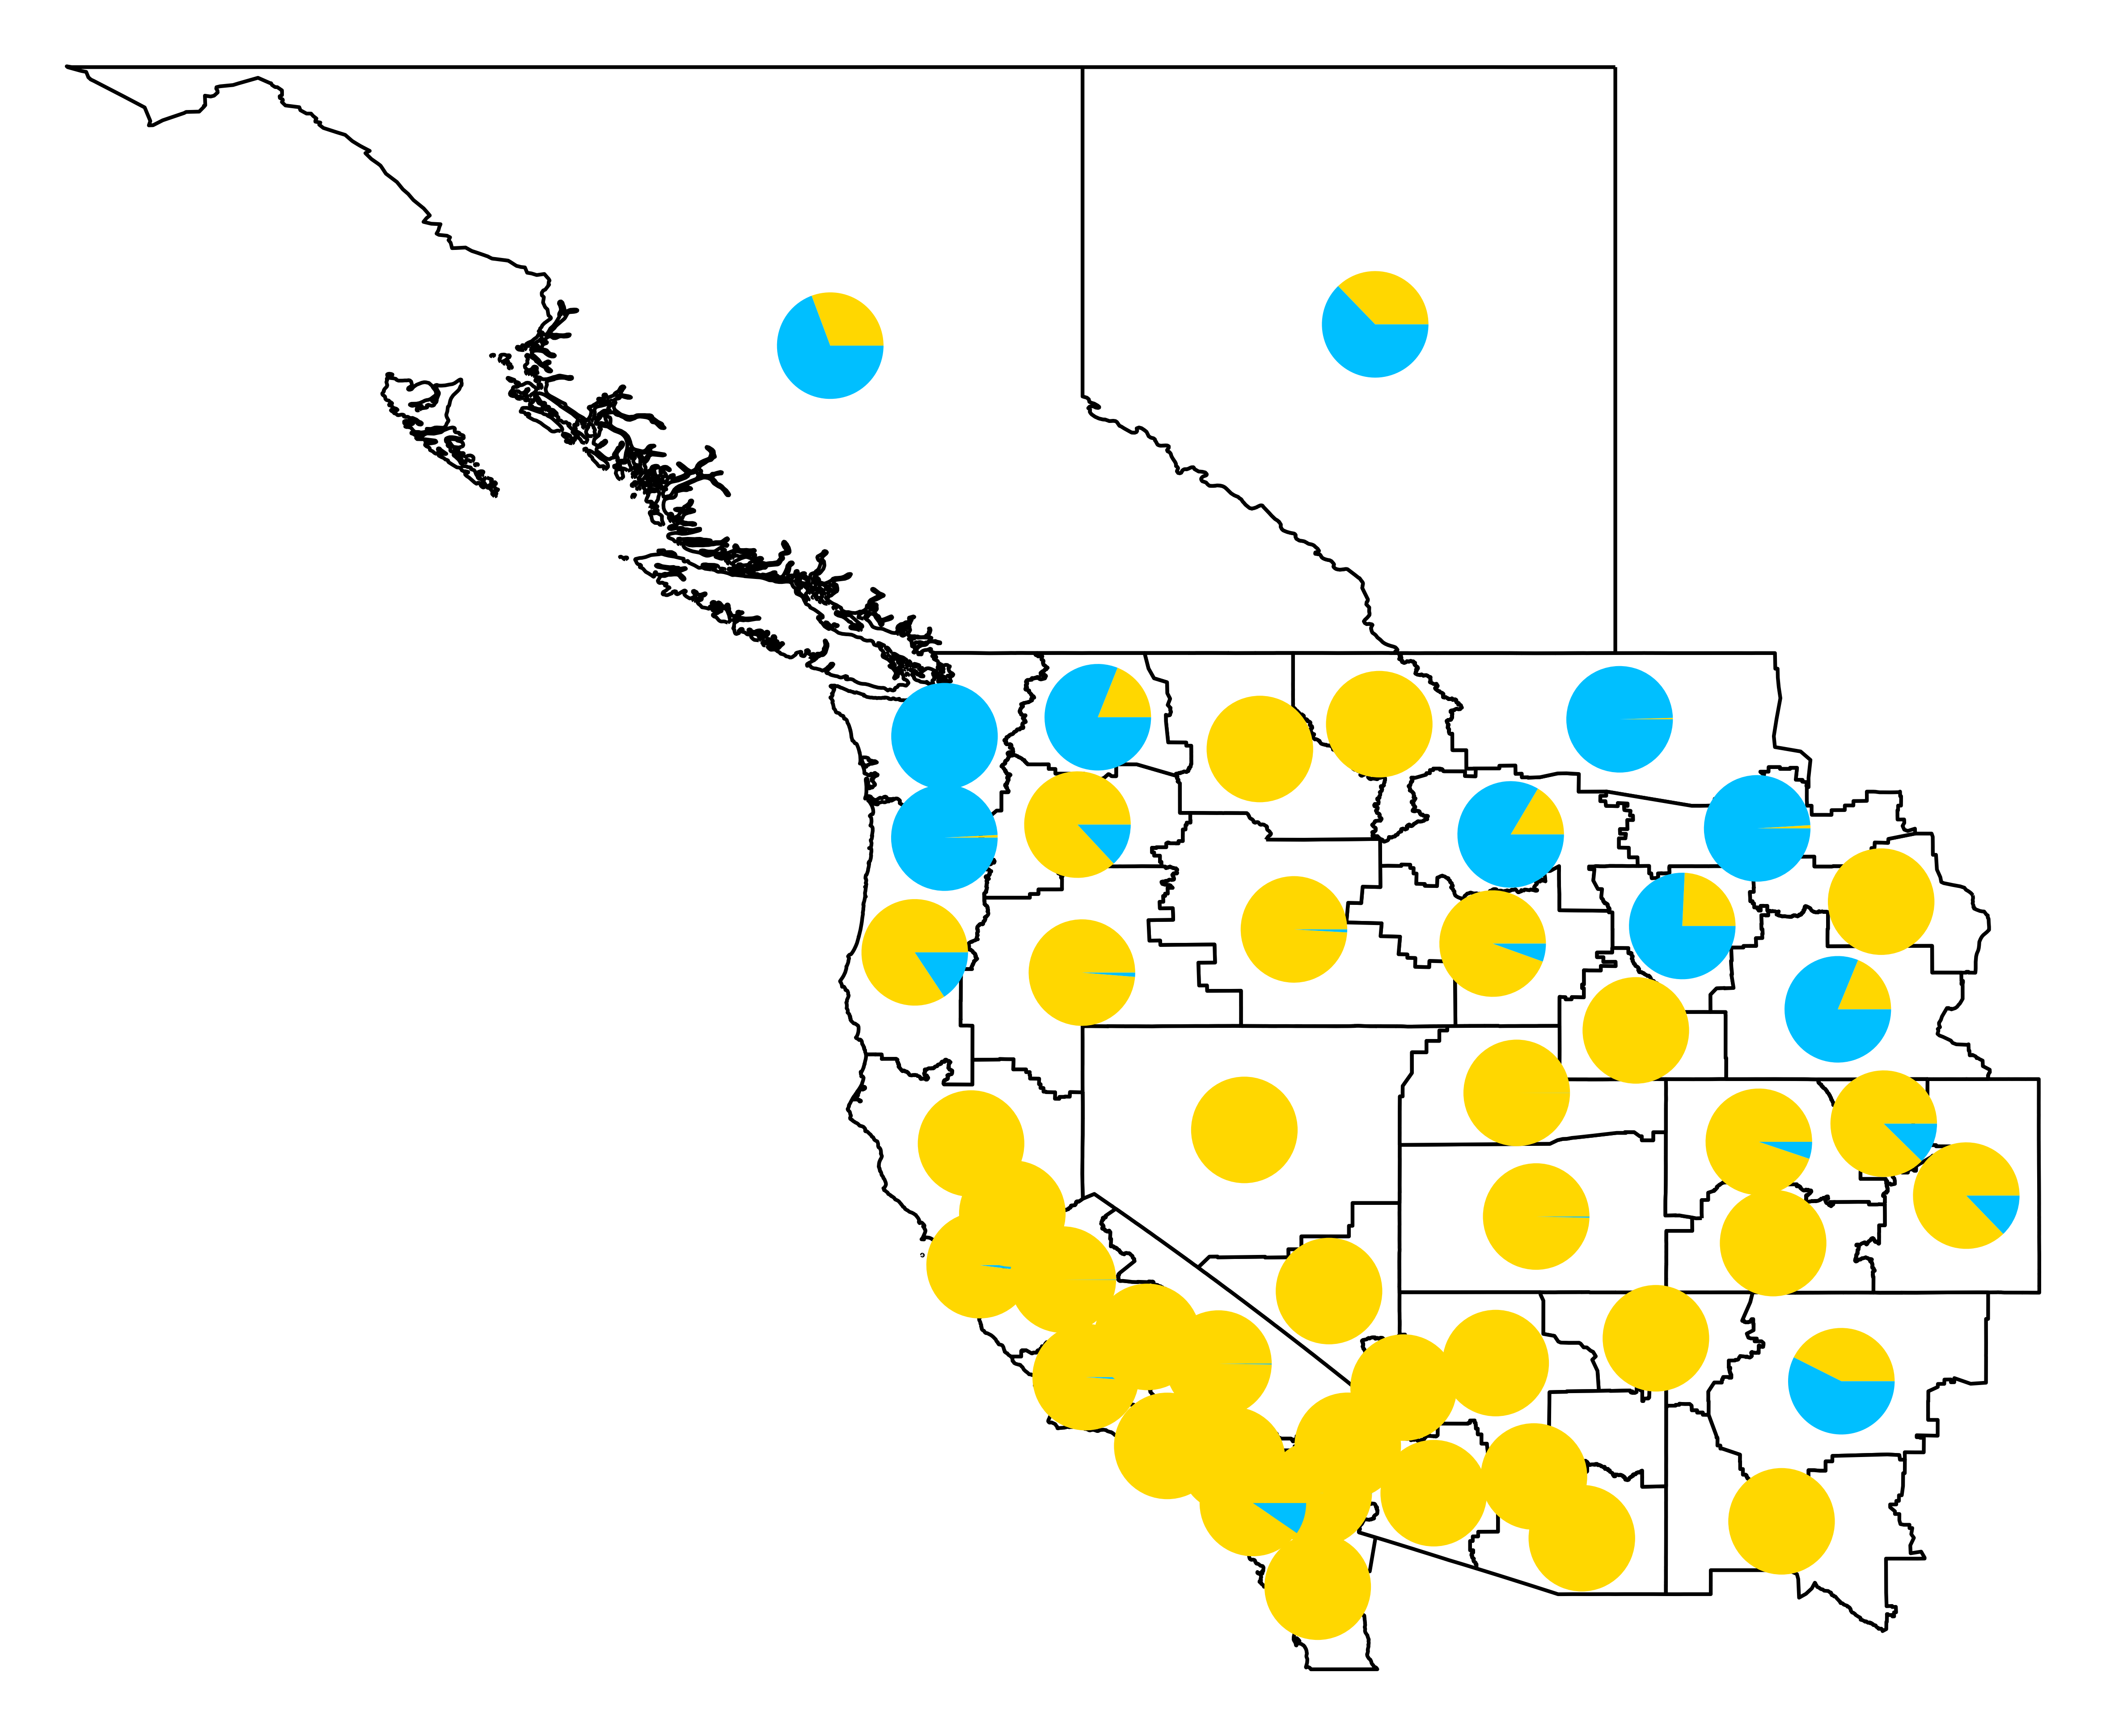

In [52]:
# Create the base map
fig, ax = plt.subplots(figsize=(10, 10))
ax = wecc_load_areas.plot(ax=ax, facecolor='white', edgecolor='black')
tech_colors_in_order = [tech_colors[i] for i in tech_order]

for idx, row in zone_annual_gen_by_tech.iterrows():
   # size = row['Total_by_zone'] / zone_annual_gen_by_tech['Total_by_zone'].max()
    proportions = row[tech_order]
    ax.pie(proportions, center=row['geometry'].centroid.coords[0], colors=tech_colors_in_order)
  
ax.set_xlim(wecc_load_areas.total_bounds[[0, 2]]- ([1,-1]))
ax.set_ylim(wecc_load_areas.total_bounds[[1, 3]]- ([1,-1]))